# Lung dataset generation:
- take pixel size fixed dataset.
- use artifacts
- use rotation augmentations
- keep the image in its full size

In [1]:
import staintools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import tifffile
import sys
import os
import numpy as np
from scipy import interpolate
from scipy.ndimage import morphology
from scipy.stats import multivariate_normal
from PIL import Image, ImageDraw
from cv2 import GaussianBlur, blur, getPerspectiveTransform, warpPerspective

from hashlib import blake2s

from deconvolution import Deconvolution
import deconvolution.pixeloperations as po


sys.path.append("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/histopath_failure_modes")
from image_manipulation import img_manip

In [2]:
TRAIN_CSV = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv"
df = pd.read_csv(TRAIN_CSV)
# df.head()
df_lung = df[df['organ'] == 'lung']
df_lung.__len__(), df['organ'].value_counts()

(48,
 kidney            99
 prostate          93
 largeintestine    58
 spleen            53
 lung              48
 Name: organ, dtype: int64)

In [3]:
def display_color_histogram(img, augmented_img, augmentation):
    augmented_img = np.array(augmented_img)
    colors = ("red", "green", "blue")
    channel_ids = (0, 1, 2)

    fig, axs = plt.subplots(1, 2, figsize = (18, 6), sharex = True, sharey = True)

    for channel_id, c in zip(channel_ids, colors):
        img = np.asarray(img)
        histogram, bin_edges = np.histogram(img[:, :, channel_id], bins = 12, range = (0, 256))
        axs[0].plot(bin_edges[0:-1], histogram, color = c, label = c)

    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_title("Original image color histogram", fontsize = 16)

    for channel_id, c in zip(channel_ids, colors):
        img = np.asarray(img)
        histogram, bin_edges = np.histogram(augmented_img[:, :, channel_id], bins = 12, range = (0, 256))
        axs[1].plot(bin_edges[0:-1], histogram, color = c, label = c)

    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_title(f"{augmentation}", fontsize = 16)

    fig.text(0.5, 0.04, 'Color value', ha='center', fontsize = 12)
    fig.text(0.04, 0.5, 'Pixel count', va='center', rotation='vertical', fontsize = 12);

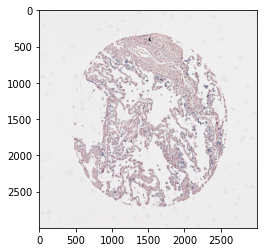

In [4]:
DIR = "/home/lakshita/somusan/hubmap_kaggle/nbs/hubmap-22-aug-pixel-size"

img_path = DIR + "/" +str(df_lung['id'].iloc[10]) + ".png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)

img_with_bubbles = img_manip.add_bubbles(im_pil, alpha=0.55, maxWidth = 120, nBubbles = 150)

plt.imshow(img_with_bubbles)

In [5]:
img.shape

(3000, 3000, 3)

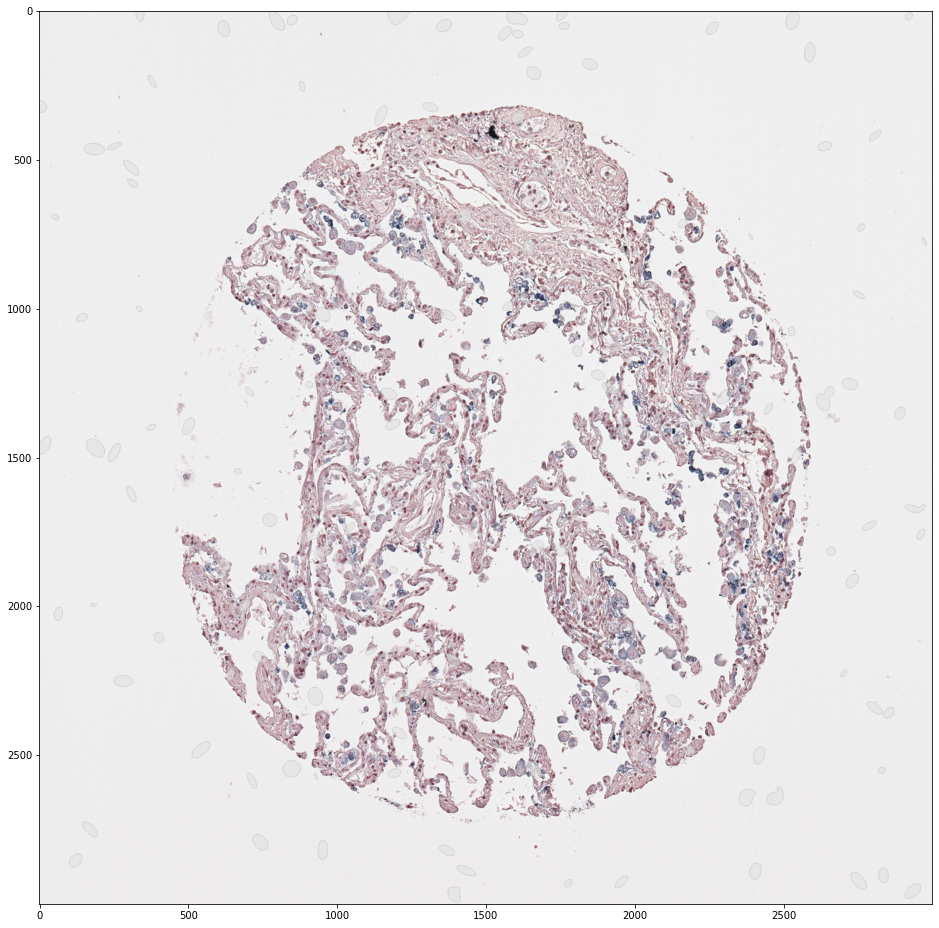

In [32]:
plt.figure(figsize=(16,18))
plt.imshow(img_with_bubbles)

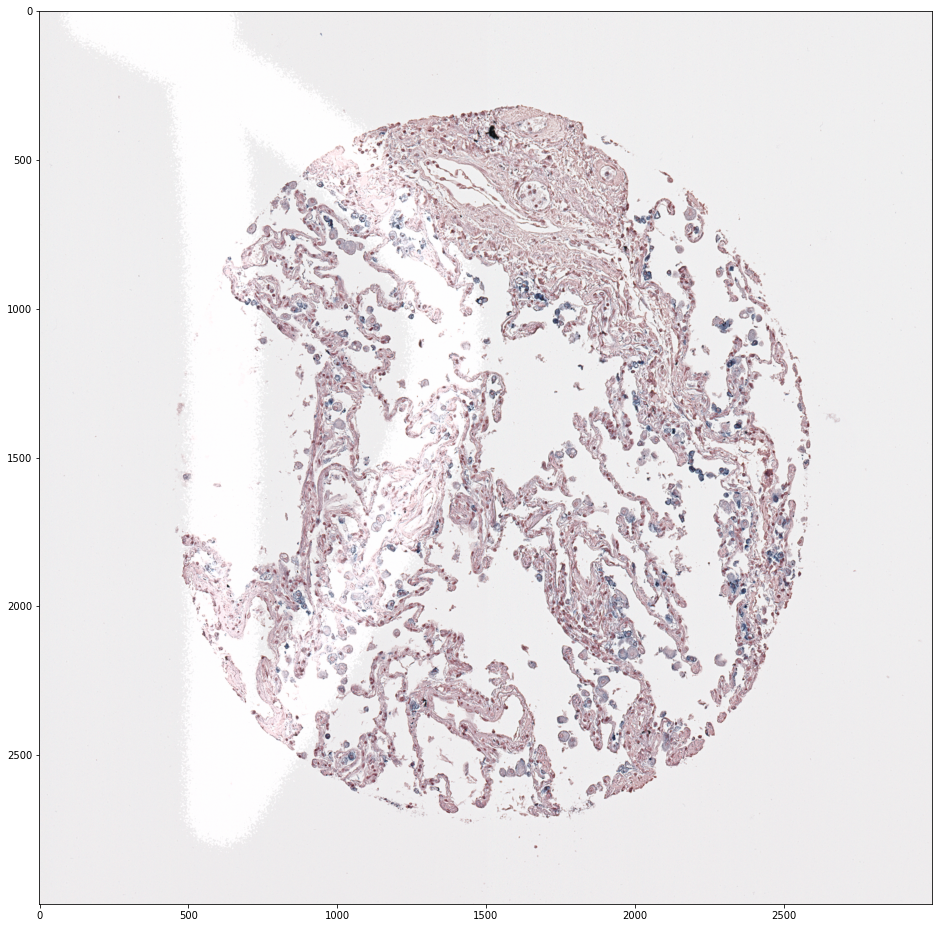

In [35]:
image_with_sectioning = img_manip.add_sectioning(im_pil,endEdge = 2, nPts=2)
plt.figure(figsize=(16,18))
plt.imshow(image_with_sectioning)

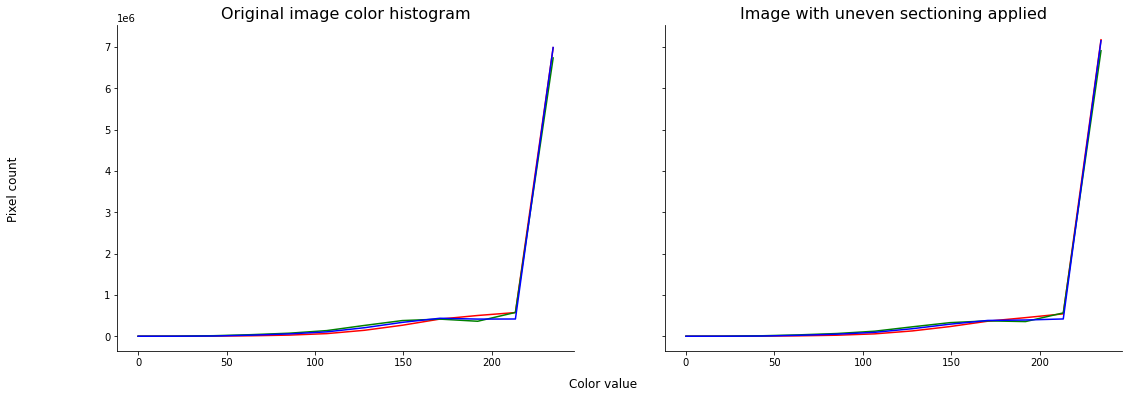

In [36]:


display_color_histogram(im_pil, image_with_sectioning, "Image with uneven sectioning applied")

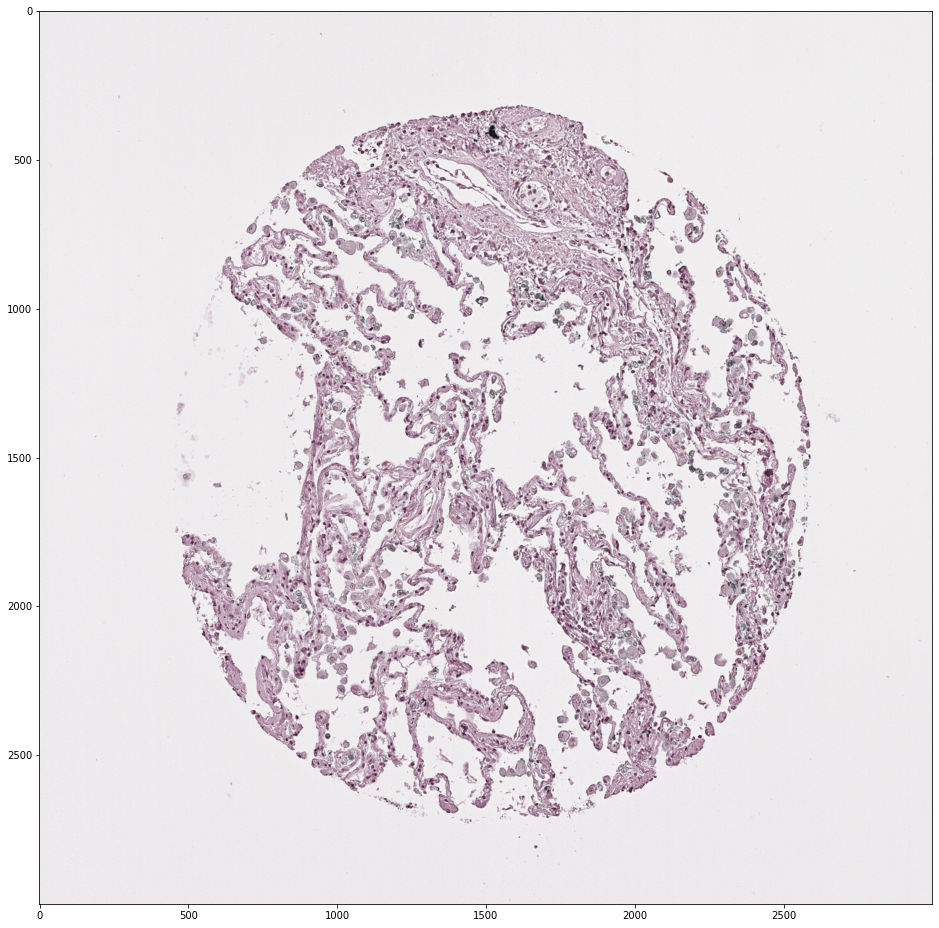

In [55]:
image_with_stain = img_manip.add_stain(im_pil, adjFactor = [1.5, 0.2, 1.0],scaleMax = [3,3,1.5], scaleMin = [1.25,1.25,1],random_seed = None)
plt.figure(figsize=(16,18))
plt.imshow(image_with_stain)

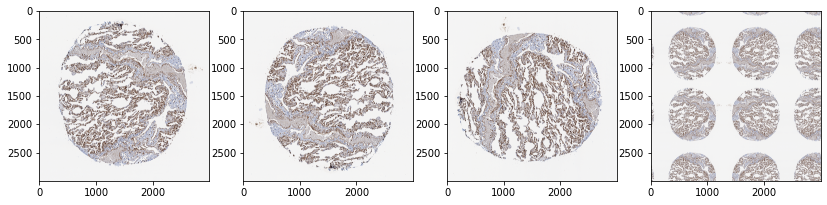

In [80]:
def do_random_flip(image, mask):
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)
    
    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

def do_random_rot90(image, mask):
    r = np.random.choice([
        0,
        cv2.ROTATE_90_CLOCKWISE,
        cv2.ROTATE_90_COUNTERCLOCKWISE,
        cv2.ROTATE_180,
    ])
    if r==0:
        return image, mask
    else:
        image = cv2.rotate(image, r)
        mask = cv2.rotate(mask, r)
        return image, mask

# albumentations                1.2.1
#---------------------------------------------------------------
from albumentations.augmentations.transforms import HorizontalFlip

transform = HorizontalFlip(p=1.0)

augmented_image = transform(image=image, mask=mask)
image  = mask['image']
mask  = mask['mask']
plt.figure(figsize=(14,18))
plt.subplot(1,4,1)
plt.imshow(Image.fromarray(augmented_image))


#---------------------------------------------------------------
from albumentations.augmentations.transforms import VerticalFlip

transform = VerticalFlip(p=1.0)

augmented_image = transform(image=img)['image']
plt.subplot(1,4,2)
plt.imshow(Image.fromarray(augmented_image))


#---------------------------------------------------------------
from albumentations.augmentations.transforms import Transpose

transform = Transpose(p=1.0)

augmented_image = transform(image=img)['image']
plt.subplot(1,4,3)
plt.imshow(Image.fromarray(augmented_image))


from albumentations.imgaug.transforms import IAAAffine

scale=0.1
translate_percent=5
translate_px=None
rotate=0
shear=0
order=1
cval=0
mode='reflect'

transform = IAAAffine(scale, translate_percent, translate_px, rotate, shear, order, cval, mode, p=1.0)

augmented_image = transform(image=img)['image']

plt.subplot(1,4,4)
plt.imshow(Image.fromarray(augmented_image))
plt.show()

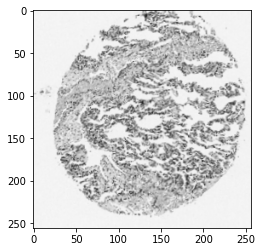

In [27]:
# https://www.kaggle.com/code/bguberfain/elastic-transform-for-data-augmentation/notebook
# https://gist.github.com/erniejunior/601cdf56d2b424757de5
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt


# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)


def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

# Load images
im = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff",3)
im_mask = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0)
im = cv2.resize(im, (256,256))
im_mask = cv2.resize(im_mask, (256,256))
# new_mask = np.zeros((256,256,3))
# new_mask[:,:,0] = im_mask[:,:,0]
# new_mask[:,:,1] = im_mask[:,:,0]

# new_mask[:,:,2] = im_mask[:,:,0]
# print(im.shape, new_mask.shape)
# im[:,:,0].shape, im_mask.shape
# # Draw grid lines
# draw_grid(im, 50)
# draw_grid(im_mask, 50)

# # Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[:,:,0].reshape(256,256,1), im_mask.reshape(256,256,1)), axis=2)


im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.12, im_merge.shape[1] * 0.12)

# # # Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# img_new = np.zeros((256,256,3))

gray_image = cv2.cvtColor(im_t, cv2.COLOR_GRAY2RGB)
plt.imshow(gray_image)

# # Display result
# plt.imshow(img_new)
# plt.tight_layout()
# plt.show()

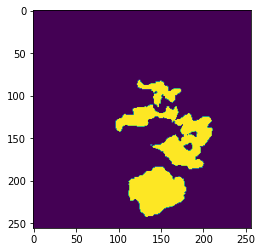

In [126]:
plt.imshow(im_mask_t)

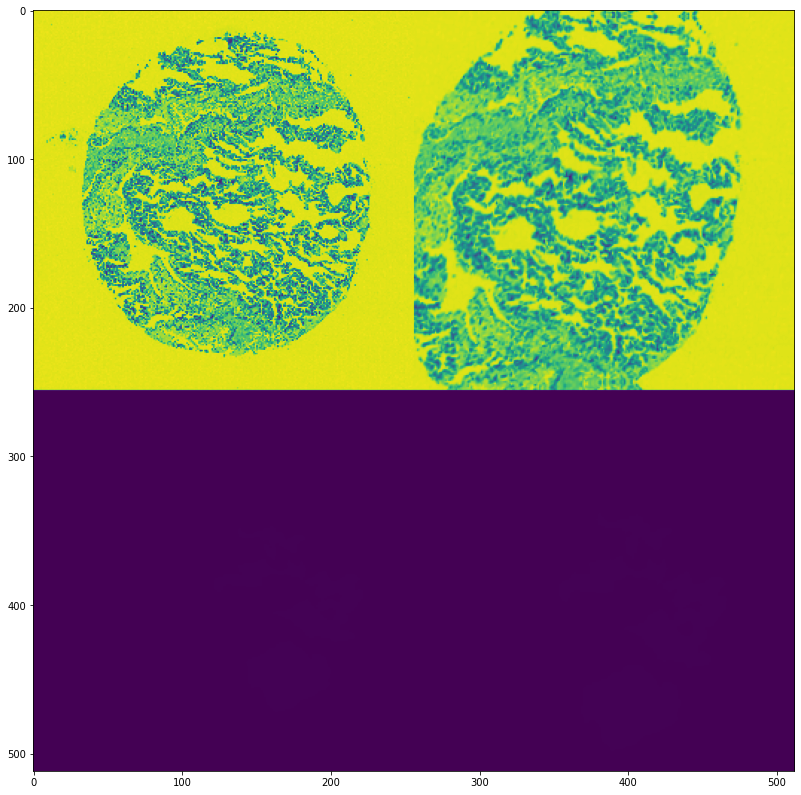

In [124]:
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[im[:,:,0], im_mask], np.r_[im_t, im_mask_t]])

In [63]:
im.shape

(3000, 3000, 3)

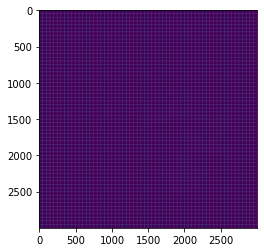

In [43]:
plt.imshow(im_mask)

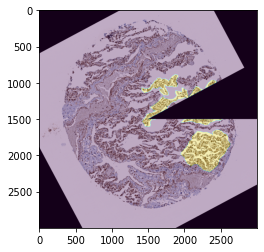

In [33]:
import imgaug as ia
import imgaug.augmenters as iaa


# seq = iaa.Sequential([
#     iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
# ], random_order=True)
seq = iaa.WithPolarWarping(
    iaa.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )
)

img_path = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0)

h,w = mask.shape

image, segmaps = seq(image=img, segmentation_maps=mask.reshape(1,h,w,1))
segmaps = segmaps.reshape(h,w)

plt.imshow(image); plt.imshow(segmaps, alpha=0.3)

In [47]:
mask.shape

(3000, 3000)

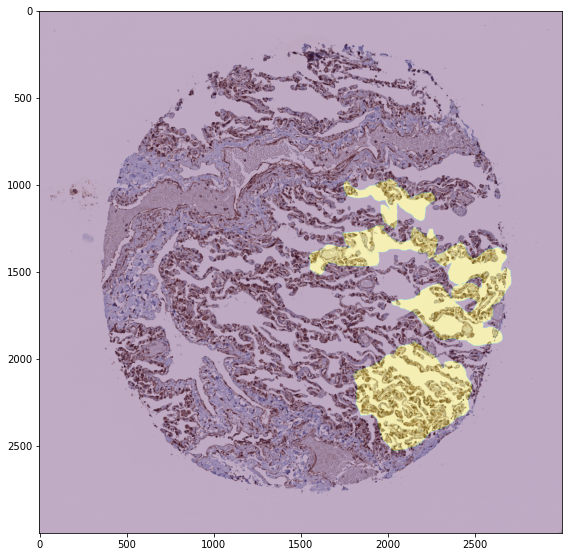

In [110]:
class LensDistortion(object):
    def __init__(self, d_coef=(0.15, 0.15, 0.1, 0.1, 0.05)):
        self.d_coef = np.array(d_coef)

    def __call__(self, X, Y):

        # get the height and the width of the image
        h, w = X.shape[:2]

        # compute its diagonal
        f = (h ** 2 + w ** 2) ** 0.5

        # set the image projective to carrtesian dimension
        K = np.array([[f, 0, w / 2],
                      [0, f, h / 2],
                      [0, 0,     1]])

        d_coef = self.d_coef * np.random.random(5) # value
        d_coef = d_coef * (2 * (np.random.random(5) < 0.5) - 1) # sign
        # Generate new camera matrix from parameters
        M, _ = cv2.getOptimalNewCameraMatrix(K, d_coef, (w, h), 0)

        # Generate look-up tables for remapping the camera image
        remap = cv2.initUndistortRectifyMap(K, d_coef, None, M, (w, h), 5)

        # Remap the original image to a new image
        X = cv2.remap(X, *remap, cv2.INTER_LINEAR)
        Y = cv2.remap(Y, *remap, cv2.INTER_LINEAR)
        return X, Y


img_path = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train_images/127.tiff"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
mask = cv2.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/mask_png/train_binary_masks/127.png", 0)

lens_des = LensDistortion()

plt.figure(figsize=(8,10))
plt.imshow(lens_des(img,mask)[0]);plt.imshow(lens_des(img,mask)[1], alpha=0.3)
plt.tight_layout()
plt.show()

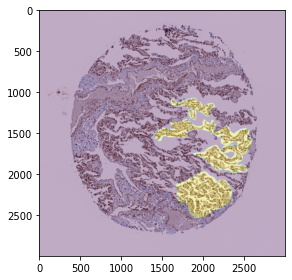

In [111]:
plt.imshow(img);plt.imshow(mask, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
aug = iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))

# List of augmentations to apply:
Geometric Augmentations:

    - transpose
    - horizontal flip
    - vertical flip
    - elastic transformation/ lens destortion

Color based Augmentations:

    - bubble,
    - stain alter
    - sectioning
    - clahe